In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

# Dataset Info

1. train.csv

train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터

item: 품목 코드

TG : 감귤

BC : 브로콜리

RD : 무

CR : 당근

CB : 양배추

corporation : 유통 법인 코드

법인 A부터 F 존재

location : 지역 코드

J : 제주도 제주시

S : 제주도 서귀포시

supply(kg) : 유통된 물량, kg 단위

price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위



2. international_trade.csv

관련 품목 수출입 정보


3. test.csv

test 데이터 : 2023년 03월 04일부터 2023년 03월 31일까지의 데이터


4. sample_submission.csv

제출을 위한 양식
2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측

ID는 품목, 유통 법인, 지역 코드로 구성된 식별자

해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함


# Load Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/sample_submission.csv')

In [ ]:
train.head(5)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [ ]:
test.head(5)

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [ ]:
trade = pd.read_csv('/content/drive/MyDrive/DACON_제주/data/international_trade.csv')
trade.head(5)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [ ]:
train.shape, test.shape

((59397, 7), (1092, 5))

In [ ]:
submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
dtypes: object(5)
memory usage: 42.8+ KB


In [ ]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [ ]:
train.columns,test.columns, submission.columns

(Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
        'price(원/kg)'],
       dtype='object'),
 Index(['ID', 'timestamp', 'item', 'corporation', 'location'], dtype='object'),
 Index(['ID', 'answer'], dtype='object'))

## timestamp 처리

In [ ]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다

train['timestamp'] = pd.to_datetime(train['timestamp'])
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day



In [ ]:
#질적 변수들을 수치화
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

## 컬럼명 바꾸기

In [ ]:
train.rename(columns={'supply(kg)': 'supply', 'price(원/kg)': 'price'}, inplace=True)

In [ ]:
train.describe()

,item,corporation,location,supply,price,year,month,day
count,59397.000000,59397.000000,59397.000000,5.939700e+04,59397.000000,59397.000000,59397.000000,59397.000000
mean,2.128205,2.230769,0.410256,1.189453e+04,1131.680674,2020.601445,6.320420,15.685489
std,1.505209,1.608669,0.491884,5.226400e+04,2029.941445,1.201092,3.519942,8.804446
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2019.000000,1.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000e+00,0.000000,2020.000000,3.000000,8.000000
50%,2.000000,2.000000,0.000000,0.000000e+00,0.000000,2021.000000,6.000000,16.000000
75%,4.000000,4.000000,1.000000,3.800000e+03,1519.000000,2022.000000,9.000000,23.000000
max,4.000000,5.000000,1.000000,1.222800e+06,20909.000000,2023.000000,12.000000,31.000000


## [ID, timestamp, supply] feature 제거

In [ ]:
train.drop(columns = ['ID', 'timestamp','supply'], axis = 1, inplace = True)
train.head(5)

,item,corporation,location,price,year,month,day
0,4,0,0,0.0,2019,1,1
1,4,0,0,0.0,2019,1,2
2,4,0,0,1728.0,2019,1,3
3,4,0,0,1408.0,2019,1,4
4,4,0,0,1250.0,2019,1,5


In [ ]:
test.drop(columns = ['ID', 'timestamp'], axis = 1, inplace = True)
test.head(5)

,item,corporation,location,year,month,day
0,4,0,0,2023,3,4
1,4,0,0,2023,3,5
2,4,0,0,2023,3,6
3,4,0,0,2023,3,7
4,4,0,0,2023,3,8


In [ ]:
test.tail()

,item,corporation,location,year,month,day
1087,3,5,0,2023,3,27
1088,3,5,0,2023,3,28
1089,3,5,0,2023,3,29
1090,3,5,0,2023,3,30
1091,3,5,0,2023,3,31


# 날짜 feature로 새로운 변수 생성

# 계절 feature

In [ ]:
# 'year', 'month', 'day' 열을 날짜 데이터로 변환
train['date'] = pd.to_datetime(train[['year', 'month', 'day']])

# 월(month) 정보를 추출하여 'season' 열 생성
train['season'] = train['date'].dt.month.apply(lambda x: (x%12 + 3)//3)  # 1: 봄, 2: 여름, 3: 가을, 4: 겨울

# 원핫 인코딩을 위해 'weekday' 열을 카테고리형으로 변환
train['season'] = train['season'].astype('category')

# 원핫 인코딩 적용
train = pd.get_dummies(train, columns=['season'], prefix='season')

In [ ]:
train.tail()

,item,corporation,location,price,year,month,day,date,season_1,season_2,season_3,season_4
59392,3,5,0,468.0,2023,2,27,2023-02-27,1,0,0,0
59393,3,5,0,531.0,2023,2,28,2023-02-28,1,0,0,0
59394,3,5,0,574.0,2023,3,1,2023-03-01,0,1,0,0
59395,3,5,0,523.0,2023,3,2,2023-03-02,0,1,0,0
59396,3,5,0,529.0,2023,3,3,2023-03-03,0,1,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   item         59397 non-null  int64         
 1   corporation  59397 non-null  int64         
 2   location     59397 non-null  int64         
 3   price        59397 non-null  float64       
 4   year         59397 non-null  int64         
 5   month        59397 non-null  int64         
 6   day          59397 non-null  int64         
 7   date         59397 non-null  datetime64[ns]
 8   season_1     59397 non-null  uint8         
 9   season_2     59397 non-null  uint8         
 10  season_3     59397 non-null  uint8         
 11  season_4     59397 non-null  uint8         
dtypes: datetime64[ns](1), float64(1), int64(6), uint8(4)
memory usage: 3.9 MB


In [ ]:
# 'year', 'month', 'day' 열을 날짜 데이터로 변환
test['date'] = pd.to_datetime(test[['year', 'month', 'day']])

# 월(month) 정보를 추출하여 'season' 열 생성
test['season'] = test['date'].dt.month.apply(lambda x: (x%12 + 3)//3)  # 1: 봄, 2: 여름, 3: 가을, 4: 겨울

# 원핫 인코딩을 위해 'season' 열을 카테고리형으로 변환
test['season'] = test['season'].astype('category')

# 원핫 인코딩 적용
test = pd.get_dummies(test, columns=['season'], prefix='season')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   item         1092 non-null   int64         
 1   corporation  1092 non-null   int64         
 2   location     1092 non-null   int64         
 3   year         1092 non-null   int64         
 4   month        1092 non-null   int64         
 5   day          1092 non-null   int64         
 6   date         1092 non-null   datetime64[ns]
 7   season_2     1092 non-null   uint8         
dtypes: datetime64[ns](1), int64(6), uint8(1)
memory usage: 60.9 KB


In [ ]:
test

,item,corporation,location,year,month,day,date,season_2
0,4,0,0,2023,3,4,2023-03-04,1
1,4,0,0,2023,3,5,2023-03-05,1
2,4,0,0,2023,3,6,2023-03-06,1
3,4,0,0,2023,3,7,2023-03-07,1
4,4,0,0,2023,3,8,2023-03-08,1
...,...,...,...,...,...,...,...,...
1087,3,5,0,2023,3,27,2023-03-27,1
1088,3,5,0,2023,3,28,2023-03-28,1
1089,3,5,0,2023,3,29,2023-03-29,1
1090,3,5,0,2023,3,30,2023-03-30,1


## 요일 feature

In [ ]:
# 요일 정보 추출 및 'weekday' 열 추가
train['weekday'] = train['date'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일

# 원핫 인코딩을 위해 'weekday' 열을 카테고리형으로 변환
train['weekday'] = train['weekday'].astype('category')

# 원핫 인코딩 적용
train = pd.get_dummies(train, columns=['weekday'], prefix='weekday')

# 'weekday' 열이 데이터프레임에 정확하게 포함되어 있는지 확인
print(train.head())


   item  corporation  location   price  year  month  day       date  season_1  \
0     4            0         0     0.0  2019      1    1 2019-01-01         1   
1     4            0         0     0.0  2019      1    2 2019-01-02         1   
2     4            0         0  1728.0  2019      1    3 2019-01-03         1   
3     4            0         0  1408.0  2019      1    4 2019-01-04         1   
4     4            0         0  1250.0  2019      1    5 2019-01-05         1   

   season_2  season_3  season_4  weekday_0  weekday_1  weekday_2  weekday_3  \
0         0         0         0          0          1          0          0   
1         0         0         0          0          0          1          0   
2         0         0         0          0          0          0          1   
3         0         0         0          0          0          0          0   
4         0         0         0          0          0          0          0   

   weekday_4  weekday_5  weekday_6  
0

In [ ]:
# 요일 정보 추출 및 'weekday' 열 추가
test['weekday'] = test['date'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일

# 원핫 인코딩을 위해 'weekday' 열을 카테고리형으로 변환
test['weekday'] = test['weekday'].astype('category')

# 원핫 인코딩 적용
test = pd.get_dummies(test, columns=['weekday'], prefix='weekday')

# 'weekday' 열이 데이터프레임에 정확하게 포함되어 있는지 확인
print(test.head())


   item  corporation  location  year  month  day       date  season_2  \
0     4            0         0  2023      3    4 2023-03-04         1   
1     4            0         0  2023      3    5 2023-03-05         1   
2     4            0         0  2023      3    6 2023-03-06         1   
3     4            0         0  2023      3    7 2023-03-07         1   
4     4            0         0  2023      3    8 2023-03-08         1   

   weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          0          0          1          0  
1          0          0          0          0          0          0          1  
2          1          0          0          0          0          0          0  
3          0          1          0          0          0          0          0  
4          0          0          1          0          0          0          0  


In [ ]:
# item 원핫인코딩..?
train['item'] = train['item'].astype('category')

# 원핫 인코딩 적용
train = pd.get_dummies(train, columns=['item'], prefix='item')


In [ ]:
# item 원핫인코딩..?
test['item'] = test['item'].astype('category')

# 원핫 인코딩 적용
test = pd.get_dummies(test, columns=['item'], prefix='item')


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   corporation  1092 non-null   int64         
 1   location     1092 non-null   int64         
 2   year         1092 non-null   int64         
 3   month        1092 non-null   int64         
 4   day          1092 non-null   int64         
 5   date         1092 non-null   datetime64[ns]
 6   season_2     1092 non-null   uint8         
 7   weekday_0    1092 non-null   uint8         
 8   weekday_1    1092 non-null   uint8         
 9   weekday_2    1092 non-null   uint8         
 10  weekday_3    1092 non-null   uint8         
 11  weekday_4    1092 non-null   uint8         
 12  weekday_5    1092 non-null   uint8         
 13  weekday_6    1092 non-null   uint8         
 14  item_0       1092 non-null   uint8         
 15  item_1       1092 non-null   uint8         
 16  item_2

In [ ]:
train.drop(columns = 'date', axis = 1, inplace = True)

In [ ]:
corr_values = train.corr()
corr_values.style.background_gradient()

,corporation,location,price,year,month,day,season_1,season_2,season_3,season_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,item_0,item_1,item_2,item_3,item_4
corporation,1.000000,-0.087244,-0.090228,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.116405,0.040342,0.057510,0.124495,-0.084240
location,-0.087244,1.000000,0.040949,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.038069,-0.163921,-0.118422,0.092685,0.107138
price,-0.090228,0.040949,1.000000,0.029442,-0.076673,0.011755,-0.041971,0.111682,0.038326,-0.106897,0.043725,0.043927,0.041550,0.041971,0.042265,0.012714,-0.226477,-0.059762,-0.185041,-0.197818,-0.236393,0.591802
year,0.000000,0.000000,0.029442,1.000000,-0.114541,-0.010426,0.127699,-0.038379,-0.047675,-0.047333,0.000761,-0.001740,-0.000179,-0.000179,0.001382,-0.000803,0.000761,0.000000,0.000000,-0.000000,0.000000,-0.000000
month,0.000000,0.000000,-0.076673,-0.114541,1.000000,0.014989,-0.304528,-0.375410,0.110722,0.585835,0.000250,0.001144,-0.000454,0.002742,0.000612,-0.000817,-0.003485,0.000000,-0.000000,-0.000000,0.000000,-0.000000
day,0.000000,-0.000000,0.011755,-0.010426,0.014989,1.000000,-0.010831,0.002551,0.009711,-0.000965,0.005174,0.003101,-0.008611,-0.001158,-0.006268,0.003467,0.004320,0.000000,-0.000000,-0.000000,0.000000,-0.000000
season_1,-0.000000,0.000000,-0.041971,0.127699,-0.304528,-0.010831,1.000000,-0.350185,-0.348313,-0.345817,-0.003541,-0.000496,-0.000496,0.003699,-0.000496,0.000662,0.000662,-0.000000,0.000000,-0.000000,0.000000,0.000000
season_2,-0.000000,0.000000,0.111682,-0.038379,-0.375410,0.002551,-0.350185,1.000000,-0.320327,-0.318031,0.000609,-0.000456,-0.000456,-0.000456,0.003912,-0.003767,0.000609,0.000000,-0.000000,-0.000000,-0.000000,0.000000
season_3,-0.000000,0.000000,0.038326,-0.047675,0.110722,0.009711,-0.348313,-0.320327,1.000000,-0.316331,0.002487,0.001423,0.001423,-0.002956,-0.002956,0.002487,-0.001902,0.000000,-0.000000,-0.000000,-0.000000,0.000000
season_4,-0.000000,-0.000000,-0.106897,-0.047333,0.585835,-0.000965,-0.345817,-0.318031,-0.316331,1.000000,0.000602,-0.000450,-0.000450,-0.000450,-0.000450,0.000602,0.000602,-0.000000,0.000000,0.000000,0.000000,-0.000000


## day feature 제거

In [ ]:
train.drop(columns = 'day', axis = 1, inplace = True)
test.drop(columns = 'day', axis = 1, inplace = True)
test.drop(columns = 'date', axis = 1, inplace = True)

In [ ]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_values, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("correlation")
# plt.show()

In [ ]:
# sns.displot(train['price'])

In [ ]:
# sns.displot(np.log(train['price']))

In [ ]:
# 이상치 식별과 제거
Q1 = train['price'].quantile(0.25)  # 1사분위수
Q3 = train['price'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

# 이상치 경계 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train = train[(train['price'] >= lower_bound) & (train['price'] <= upper_bound)]

# 이상치가 제거된 데이터프레임 확인
train.head()


,corporation,location,price,year,month,season_1,season_2,season_3,season_4,weekday_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,item_0,item_1,item_2,item_3,item_4
0,0,0,0.0,2019,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.0,2019,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,1728.0,2019,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,1408.0,2019,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,1250.0,2019,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
# nrows, ncols = 2, 4
# fig, axes = plt.subplots(nrows, ncols)

# plt.tight_layout()
# fig.set_size_inches(6*ncols, 6*nrows)

# sns.boxplot(x = 'item', y = 'price', data = train, ax = axes[0,0])
# sns.boxplot(x = 'corporation', y = 'price', data = train, ax = axes[0,1])
# sns.boxplot(x = 'location', y = 'price', data = train, ax = axes[0,2])
# sns.boxplot(x = 'year', y = 'price', data = train, ax = axes[0,3])
# sns.boxplot(x = 'month', y = 'price', data = train, ax = axes[1,0])
# sns.boxplot(x = 'day', y = 'price', data = train, ax = axes[1,1])
# sns.boxplot(x = 'season', y = 'price', data = train, ax = axes[1,2])
# sns.boxplot(x = 'weekday', y = 'price', data = train, ax = axes[1,3])


# plt.show()

In [ ]:
# plt.plot(train['season'], train['price'], marker='o', linestyle='-', color='b', label='선 그래프')
# plt.xlabel('season')
# plt.ylabel('price')
# plt.legend()  # 범례 추가
# plt.grid(True)  # 그리드 표시

# # 그래프 표시
# plt.show()

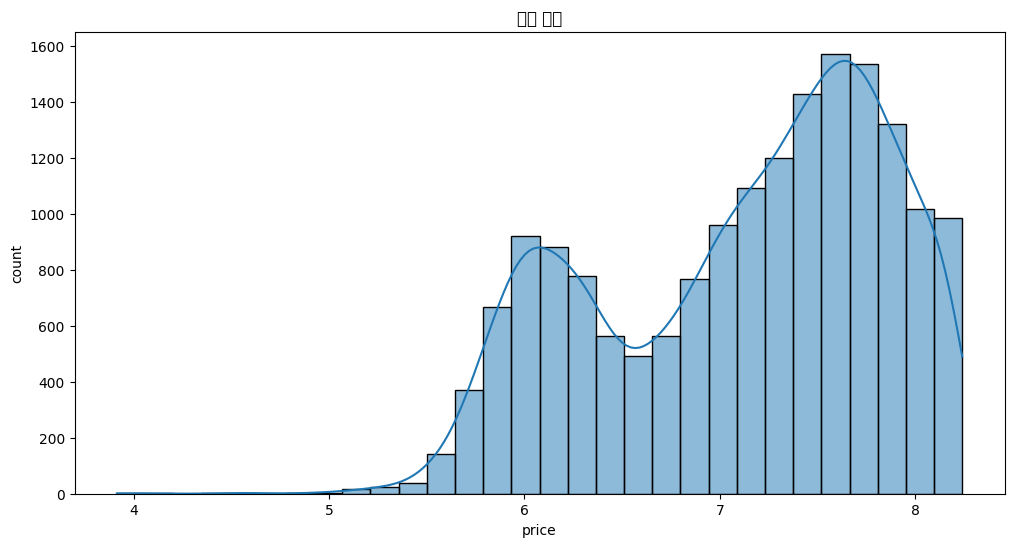

In [ ]:
# 데이터 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(np.log(train['price']), bins=30, kde=True)  # 가격 데이터에 대한 히스토그램과 KDE 그래프
plt.title('가격 분포')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

# 학습

In [ ]:
print(train.columns)
print(test.columns)

# --> test에 season1,3,4 값 추가 해야함

Index(['corporation', 'location', 'price', 'year', 'month', 'season_1',
       'season_2', 'season_3', 'season_4', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'item_0', 'item_1', 'item_2', 'item_3', 'item_4'],
      dtype='object')
Index(['corporation', 'location', 'year', 'month', 'season_2', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4'],
      dtype='object')


In [ ]:
# test에 season1,3,4 값 추가
test['season_1']=0
test['season_3']=0
test['season_4']=0

In [ ]:
test = test[['corporation', 'location', 'year', 'month', 'season_1', 'season_2', 'season_3', 'season_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4']]

In [ ]:
train.shape, test.shape

((52795, 21), (1092, 20))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52795 entries, 0 to 59396
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   corporation  52795 non-null  int64  
 1   location     52795 non-null  int64  
 2   price        52795 non-null  float64
 3   year         52795 non-null  int64  
 4   month        52795 non-null  int64  
 5   season_1     52795 non-null  uint8  
 6   season_2     52795 non-null  uint8  
 7   season_3     52795 non-null  uint8  
 8   season_4     52795 non-null  uint8  
 9   weekday_0    52795 non-null  uint8  
 10  weekday_1    52795 non-null  uint8  
 11  weekday_2    52795 non-null  uint8  
 12  weekday_3    52795 non-null  uint8  
 13  weekday_4    52795 non-null  uint8  
 14  weekday_5    52795 non-null  uint8  
 15  weekday_6    52795 non-null  uint8  
 16  item_0       52795 non-null  uint8  
 17  item_1       52795 non-null  uint8  
 18  item_2       52795 non-null  uint8  
 19  item

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   corporation  1092 non-null   int64
 1   location     1092 non-null   int64
 2   year         1092 non-null   int64
 3   month        1092 non-null   int64
 4   season_1     1092 non-null   int64
 5   season_2     1092 non-null   uint8
 6   season_3     1092 non-null   int64
 7   season_4     1092 non-null   int64
 8   weekday_0    1092 non-null   uint8
 9   weekday_1    1092 non-null   uint8
 10  weekday_2    1092 non-null   uint8
 11  weekday_3    1092 non-null   uint8
 12  weekday_4    1092 non-null   uint8
 13  weekday_5    1092 non-null   uint8
 14  weekday_6    1092 non-null   uint8
 15  item_0       1092 non-null   uint8
 16  item_1       1092 non-null   uint8
 17  item_2       1092 non-null   uint8
 18  item_3       1092 non-null   uint8
 19  item_4       1092 non-null   uint8
dtypes: int64

In [ ]:
# datetime 타입 수치형으로 변환
# train['year'] = pd.to_numeric(train['year'])
# train['month'] = pd.to_numeric(train['month'])
# test['year'] = pd.to_numeric(test['year'])
# test['month'] = pd.to_numeric(test['month'])
# test['day'] = pd.to_numeric(test['day'])
#test['date'] = pd.to_numeric(test['date'])

In [ ]:
# 모델 : 'xgboost', 'lightgbm', 'catboost', 'random_forest'
# 스태킹 앙상블 적용

In [ ]:
# 훈련용 데이터 준비
y = train['price']
X = train.drop(['price'], axis=1)

X.shape, y.shape

((52795, 20), (52795,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31677, 20), (21118, 20), (31677,), (21118,))

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=20)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=20)

# X_train.shape, X_test.shape, X_val.shape, X_temp.shape, y_train.shape, y_test.shape, y_val.shape, y_temp.shape

## XGBRegressor

In [ ]:
!pip install xgboost

In [ ]:
'''
XGBoost (Extreme Gradient Boosting):

    - max_depth = 9:
    - eta (learning_rate) = 0.01: 학습률. 경사 하강법에서의 스텝 크기를 조절.
    - colsample_bytree = 0.66: 각 트리에서 특성의 샘플링 비율.
    - subsample = 0.76: 각 반복에서 사용할 학습 데이터의 샘플링 비율.
    - min_child_weight = 22: 각 리프 노드가 가질 수 있는 최소 가중치 합계를 제한.
    - lambda (reg_lambda) = 16:
    - gamma (reg_alpha) = 1: L1 규제 (가중치 감쇠) 계수. 모델의 복잡성을 제어.
		- tree_method = 'gpu_hist': 트리 학습에 사용할 방법을 설정. gpu_hist:GPU 학습 사용
    - booster: 기본값인 "gbtree"는 트리 부스팅을 의미
    - eval_metric = 'RMSE' : 모델의 성능을 평가할 때 사용할 평가 지표를 설정.
    - num_boost_round (n_estimators) = 50000: 부스팅 반복의 총 횟수를 설정합니다.

'''

'\nXGBoost (Extreme Gradient Boosting):\n\n    - max_depth = 9:\n    - eta (learning_rate) = 0.01: 학습률. 경사 하강법에서의 스텝 크기를 조절.\n    - colsample_bytree = 0.66: 각 트리에서 특성의 샘플링 비율.\n    - subsample = 0.76: 각 반복에서 사용할 학습 데이터의 샘플링 비율.\n    - min_child_weight = 22: 각 리프 노드가 가질 수 있는 최소 가중치 합계를 제한.\n    - lambda (reg_lambda) = 16:\n    - gamma (reg_alpha) = 1: L1 규제 (가중치 감쇠) 계수. 모델의 복잡성을 제어.\n\t\t- tree_method = \'gpu_hist\': 트리 학습에 사용할 방법을 설정. gpu_hist:GPU 학습 사용\n    - booster: 기본값인 "gbtree"는 트리 부스팅을 의미\n    - eval_metric = \'RMSE\' : 모델의 성능을 평가할 때 사용할 평가 지표를 설정.\n    - num_boost_round (n_estimators) = 50000: 부스팅 반복의 총 횟수를 설정합니다.\n\n'

In [ ]:
from xgboost import XGBRegressor

# XGBRegressor 모델 선언 후 Fitting
xgbr = XGBRegressor(
                    max_depth = 9,
                    colsample_bytree = 0.66,
                    subsample = 0.76,
                    min_child_weight = 22,
                    gamma = 1,
                    booster = 'gbtree',
                    num_boost_round = 50000
)
xgbr.fit(X_train, y_train)

# Fitting된 모델로 x_valid를 통해 예측을 진행
xgbr_pred = xgbr.predict(test)

In [ ]:
xgbr_pred.shape

(1092,)

In [ ]:
from sklearn.metrics import mean_squared_error

#RMSE = mean_squared_error(y_test, xgbr_pred, squared=False)**0.5
#RMSE

In [ ]:
#RMSE = mean_squared_error(y_val, xgbr_pred, squared=False)**0.5
#RMSE

## LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
'''
LightGBM (Light Gradient Boosting Machine):

    - max_depth = 9: 트리의 최대 깊이.
    - learning_rate = 0.01: 경사 하강법에서의 학습률. 학습 속도를 조절하는 데 사용.
    - min_data_in_leaf = 36: 리프 노드에 필요한 최소 데이터 포인트 수.
    - num_leaves = 100: 생성될 최대 리프 노드 수. 트리의 복잡성을 조절.
    - feature_fraction = 0.8: 각 트리에 사용할 특성의 비율.
    - bagging_fraction = 0.89: 각 반복에서 사용할 학습 데이터의 일부 비율.
    - bagging_freq = 5: 랜덤 샘플링을 얼마나 자주 적용할지를 설정.
		- lambda_l2 = 28: L2 규제는 모델 가중치에 대한 L2 페널티를 적용하여 과적합을 제어.
    - seed = 228 : 모델의 재현성을 위해 난수 시드를 설정.
    - boosting_type : 부스팅 알고리즘 중 하나를 선택.
				기본값인 'gbdt'는 일반적인 Gradient Boosting Decision Tree를 의미.
		- metric: 모델의 성능을 측정하기 위해 사용되는 평가 지표를 설정.
				'rmse': 평균 제곱근 오차 사용
    - 기타 파라미터: 'device', 'gpu_platform_id', 'gpu_device_id': GPU 학습을 위한 설정.

'''

"\nLightGBM (Light Gradient Boosting Machine):\n\n    - max_depth = 9: 트리의 최대 깊이.\n    - learning_rate = 0.01: 경사 하강법에서의 학습률. 학습 속도를 조절하는 데 사용.\n    - min_data_in_leaf = 36: 리프 노드에 필요한 최소 데이터 포인트 수.\n    - num_leaves = 100: 생성될 최대 리프 노드 수. 트리의 복잡성을 조절.\n    - feature_fraction = 0.8: 각 트리에 사용할 특성의 비율.\n    - bagging_fraction = 0.89: 각 반복에서 사용할 학습 데이터의 일부 비율.\n    - bagging_freq = 5: 랜덤 샘플링을 얼마나 자주 적용할지를 설정.\n\t\t- lambda_l2 = 28: L2 규제는 모델 가중치에 대한 L2 페널티를 적용하여 과적합을 제어.\n    - seed = 228 : 모델의 재현성을 위해 난수 시드를 설정.\n    - boosting_type : 부스팅 알고리즘 중 하나를 선택.\n\t\t\t\t기본값인 'gbdt'는 일반적인 Gradient Boosting Decision Tree를 의미.\n\t\t- metric: 모델의 성능을 측정하기 위해 사용되는 평가 지표를 설정.\n\t\t\t\t'rmse': 평균 제곱근 오차 사용\n    - 기타 파라미터: 'device', 'gpu_platform_id', 'gpu_device_id': GPU 학습을 위한 설정.\n\n"

In [ ]:
from lightgbm import LGBMRegressor

# LGBMRegressor 모델 선언 후 Fitting
lgbr = LGBMRegressor(
                      max_depth = 9,
                      learning_rate = 0.01,
                      num_leaves = 100,
                      seed = 228,
                      boosting_type='gbdt',
                      metric='RMSE',
                      force_row_wise=True
)
lgbr.fit(X_train, y_train)

# Fitting된 모델로 x_valid를 통해 예측을 진행
lgbr_pred = lgbr.predict(test)

[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 31677, number of used features: 20
[LightGBM] [Info] Start training from score 509.689333


In [ ]:
lgbr_pred.shape

(1092,)

In [ ]:
#RMSE = mean_squared_error(y, lgbr_pred, squared=False)**0.5
#RMSE

## CatBoostRegressor

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
'''
CatBoost:

    - depth = 9:
    - learning_rate = 0.01:
    - rsm (colsample_bylevel) = 0.88: 각 레벨별로 특성의 샘플링 비율.
    - subsample = 0.795: 각 반복에서 사용할 학습 데이터의 샘플링 비율.
    - l2_leaf_reg = 8: L2 규제 (가중치 감쇠) 계수. 모델의 복잡성을 제어.
		- min_data_in_leaf = 35
    - random_strength = 0.63: 트리에서 무작위성을 추가하는 강도를 설. 모델의 다양성을 증가.
    - use_best_model = True: 최상의 반복에서 얻은 모델을 사용할지 여부를 결정.
    - task_type = 'CPU': CPU 또는 GPU에서 학습 작업을 수행할지 여부를 설정.
    - bootstrap_type = 'Bernoulli: 부트스트랩 방법을 설정, 데이터 포인트를 재샘플링 방식을 결정
    - grow_policy = 'SymmertricTree' : 트리를 어떻게 성장시킬지 선택.
		- loss_function = 'RMSE': 모델 학습 중에 최소화하려는 손실 함수를 설정.
    - eval_metric= 'RMSE': 모델의 성능을 측정하기 위해 사용되는 평가 지표를 설정합니다.

'''

"\nCatBoost:\n\n    - depth = 9:\n    - learning_rate = 0.01:\n    - rsm (colsample_bylevel) = 0.88: 각 레벨별로 특성의 샘플링 비율.\n    - subsample = 0.795: 각 반복에서 사용할 학습 데이터의 샘플링 비율.\n    - l2_leaf_reg = 8: L2 규제 (가중치 감쇠) 계수. 모델의 복잡성을 제어.\n\t\t- min_data_in_leaf = 35\n    - random_strength = 0.63: 트리에서 무작위성을 추가하는 강도를 설. 모델의 다양성을 증가.\n    - use_best_model = True: 최상의 반복에서 얻은 모델을 사용할지 여부를 결정.\n    - task_type = 'CPU': CPU 또는 GPU에서 학습 작업을 수행할지 여부를 설정.\n    - bootstrap_type = 'Bernoulli: 부트스트랩 방법을 설정, 데이터 포인트를 재샘플링 방식을 결정\n    - grow_policy = 'SymmertricTree' : 트리를 어떻게 성장시킬지 선택.\n\t\t- loss_function = 'RMSE': 모델 학습 중에 최소화하려는 손실 함수를 설정.\n    - eval_metric= 'RMSE': 모델의 성능을 측정하기 위해 사용되는 평가 지표를 설정합니다.\n\n"

In [ ]:
# CatBoostRegressor 모델 생성
cb = CatBoostRegressor(
                          depth = 9,
                          l2_leaf_reg = 8,
                          random_strength = 0.63,
                          loss_function = 'RMSE',
                          eval_metric = 'RMSE',
                          rsm = 0.88,
                          iterations=1000,  # 반복 횟수 설정
                          learning_rate=0.01,  # 학습률 설정
                          verbose=200  # 학습 과정 출력 설정
                         )

# 모델 훈련
cb.fit(X_train, y_train, early_stopping_rounds=100, verbose=200)
cb_pred = cb.predict(test)

0:	learn: 903.2580082	total: 84.5ms	remaining: 1m 24s
200:	learn: 519.5910695	total: 2.19s	remaining: 8.73s
400:	learn: 475.1562392	total: 3.52s	remaining: 5.25s
600:	learn: 457.1068516	total: 5.67s	remaining: 3.77s
800:	learn: 445.7820984	total: 8.97s	remaining: 2.23s
999:	learn: 437.0636555	total: 14.3s	remaining: 0us


In [ ]:
#RMSE = mean_squared_error(y, cb_pred, squared=False)**0.5
#RMSE

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor 모델 선언 후 Fitting
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

# Fitting된 모델로 x_valid를 통해 예측을 진행
rfr_pred = rfr.predict(test)

In [ ]:
#RMSE = mean_squared_error(y, rfr_pred, squared=False)**0.5
#RMSE

## Ensemble

In [ ]:
print(lgbr_pred.shape)
print(cb_pred.shape)
print(xgbr_pred.shape)
print(rfr_pred.shape)


(1092,)
(1092,)
(1092,)
(1092,)


In [ ]:
# 모델 예측값을 predictions 변수에 더해서 최종 예측값 생성
predictions = lgbr_pred * 0.25 + cb_pred * 0.25 + xgbr_pred * 0.25 + rfr_pred * 0.25
predictions.shape

(1092,)

In [ ]:
# 최종 예측값(submission['MedHouseVal'])을 저장
submission['answer'] = predictions
submission.to_csv('submission_ja.csv', index=False)

In [ ]:
submission['answer']

0       2471.824845
1         92.001355
2       2693.705829
3       2570.955773
4       2370.082531
           ...     
1087     507.194360
1088     483.689216
1089     508.980948
1090     501.371998
1091     527.328496
Name: answer, Length: 1092, dtype: float64

In [ ]:
submission.columns

Index(['ID', 'answer'], dtype='object')